# Chapter 17: Signal processing

Robert Johansson

Source code listings for [Numerical Python - Scientific Computing and Data Science Applications with Numpy, SciPy and Matplotlib](https://link.springer.com/book/10.1007/979-8-8688-0413-7) (ISBN 979-8-8688-0412-0).

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
import matplotlib as mpl

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.sans-serif"] = "stix"

# sns.set(style="whitegrid")

In [6]:
import matplotlib as mpl

In [7]:
from scipy import fftpack

In [8]:
# this also works:
# from numpy import fft as fftpack

In [9]:
from scipy import signal

In [10]:
import scipy.io.wavfile

In [11]:
from scipy import io

## Spectral analysis of simulated signal

In [12]:
def signal_samples(t):
    """Simulated signal samples"""
    return (
        2 * np.sin(1 * 2 * np.pi * t)
        + 3 * np.sin(22 * 2 * np.pi * t)
        + 2 * np.random.randn(*np.shape(t))
    )

In [13]:
np.random.seed(0)

In [14]:
B = 30.0

In [15]:
f_s = 2 * B
f_s

60.0

In [16]:
delta_f = 0.01

In [17]:
N = int(f_s / delta_f)
N

6000

In [18]:
T = N / f_s
T

100.0

In [19]:
f_s / N

0.01

In [20]:
t = np.linspace(0, T, N)

In [21]:
f_t = signal_samples(t)

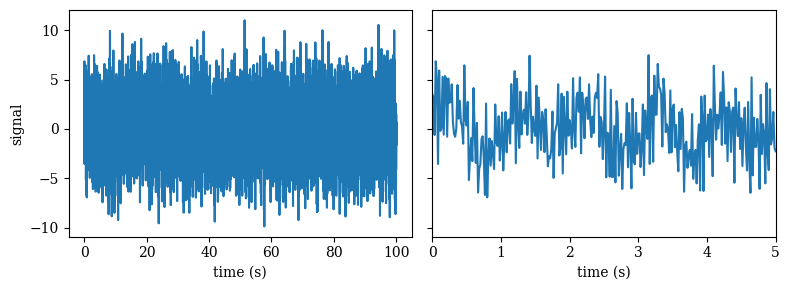

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].plot(t, f_t)
axes[0].set_xlabel("time (s)")
axes[0].set_ylabel("signal")
axes[1].plot(t, f_t)
axes[1].set_xlim(0, 5)
axes[1].set_xlabel("time (s)")
fig.tight_layout()
fig.savefig("ch17-simulated-signal.pdf")
fig.savefig("ch17-simulated-signal.png")

In [23]:
F = fftpack.fft(f_t)

In [24]:
f = fftpack.fftfreq(N, 1 / f_s)

In [25]:
mask = np.where(f >= 0)

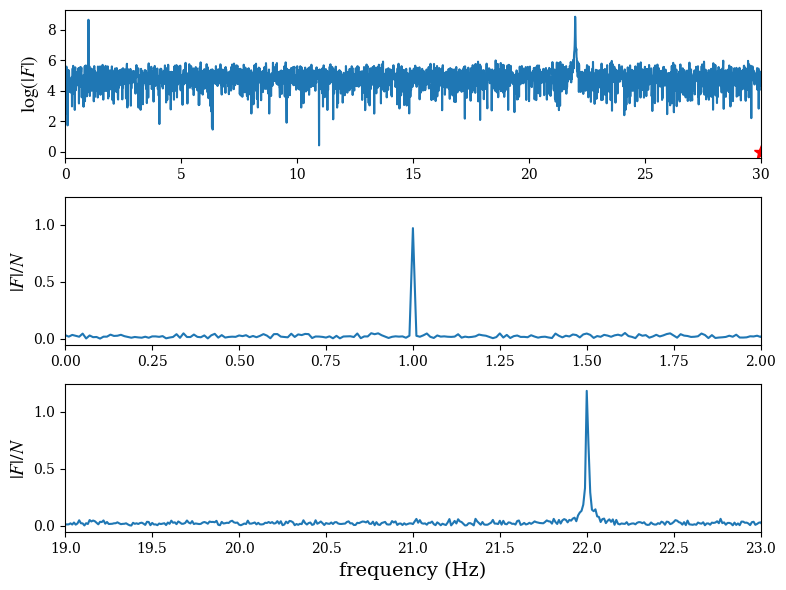

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].plot(f[mask], np.log(abs(F[mask])))
axes[0].plot(B, 0, "r*", markersize=10)
axes[0].set_xlim(0, 30)
axes[0].set_ylabel("$\log(|F|)$", fontsize=14)

axes[1].plot(f[mask], abs(F[mask]) / N)
axes[1].set_xlim(0, 2)
axes[1].set_ylabel("$|F|/N$", fontsize=14)

axes[2].plot(f[mask], abs(F[mask]) / N)
axes[2].set_xlim(19, 23)
axes[2].set_xlabel("frequency (Hz)", fontsize=14)
axes[2].set_ylabel("$|F|/N$", fontsize=14)

fig.tight_layout()
fig.savefig("ch17-simulated-signal-spectrum.pdf")
fig.savefig("ch17-simulated-signal-spectrum.png")

## Simple example of filtering

In [27]:
F_filtered = F * (abs(f) <= 2)

In [28]:
f_t_filtered = fftpack.ifft(F_filtered)

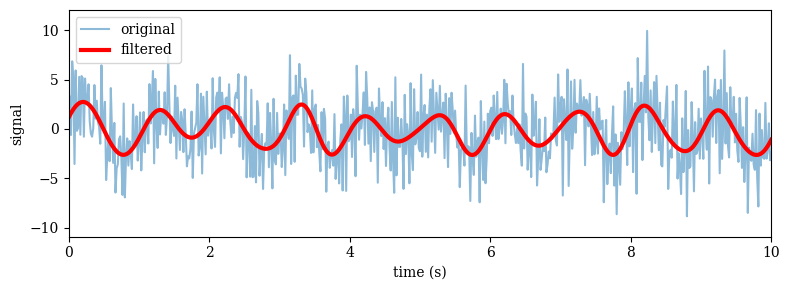

In [29]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, f_t, label="original", alpha=0.5)
ax.plot(t, f_t_filtered.real, color="red", lw=3, label="filtered")
ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
ax.legend(loc=2)
fig.tight_layout()
fig.savefig("ch17-inverse-fft.pdf")
fig.savefig("ch17-inverse-fft.png")

## Windowing

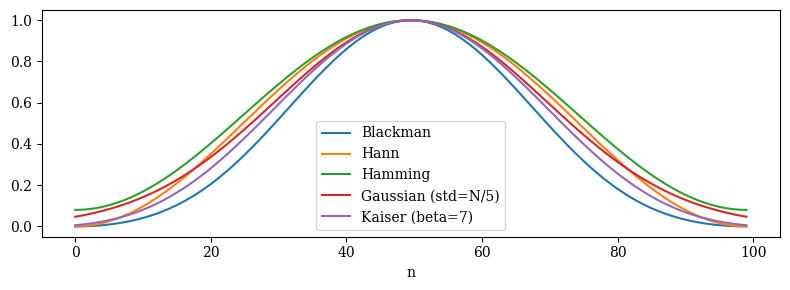

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
N = 100
ax.plot(signal.windows.blackman(N), label="Blackman")
ax.plot(signal.windows.hann(N), label="Hann")
ax.plot(signal.windows.hamming(N), label="Hamming")
ax.plot(signal.windows.gaussian(N, N / 5), label="Gaussian (std=N/5)")
ax.plot(signal.windows.kaiser(N, 7), label="Kaiser (beta=7)")
ax.set_xlabel("n")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-window-functions.pdf")

In [31]:
df = pd.read_csv(
    "temperature_outdoor_2014.tsv", delimiter="\t", names=["time", "temperature"]
)

In [32]:
df.time = (
    pd.to_datetime(df.time.values, unit="s")
    .tz_localize("UTC")
    .tz_convert("Europe/Stockholm")
)

In [33]:
df = df.set_index("time")

In [34]:
df = df.resample("1H").ffill()

/tmp/ipykernel_158175/1662368164.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("1H").ffill()


In [35]:
df = df[(df.index >= "2014-01-01") * (df.index < "2014-06-01")].dropna()

In [36]:
df = df[(df.index >= "2014-04-01") * (df.index < "2014-06-01")].dropna()

In [37]:
time = df.index.astype("int") / 1e9

In [38]:
temperature = df.temperature.values

In [39]:
temperature_detrended = signal.detrend(temperature)

In [40]:
window = signal.windows.blackman(len(temperature_detrended))

In [41]:
temperature_windowed = temperature * window

In [42]:
data_fft = fftpack.fft(temperature)
data_fft_detrended = fftpack.fft(temperature_detrended)
data_fft_windowed = fftpack.fft(temperature_windowed)

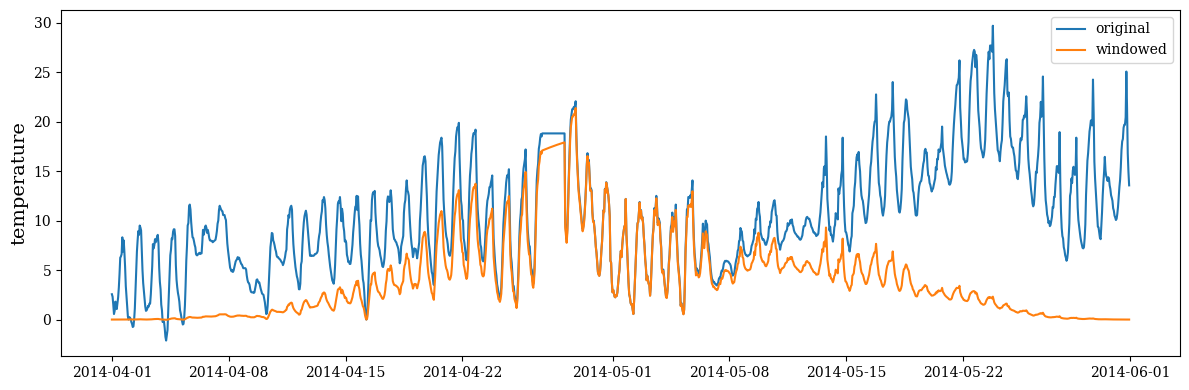

In [43]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index, temperature, label="original")
# ax.plot(df.index, temperature_detrended, label="detrended")
ax.plot(df.index, temperature_windowed, label="windowed")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-signal.pdf")

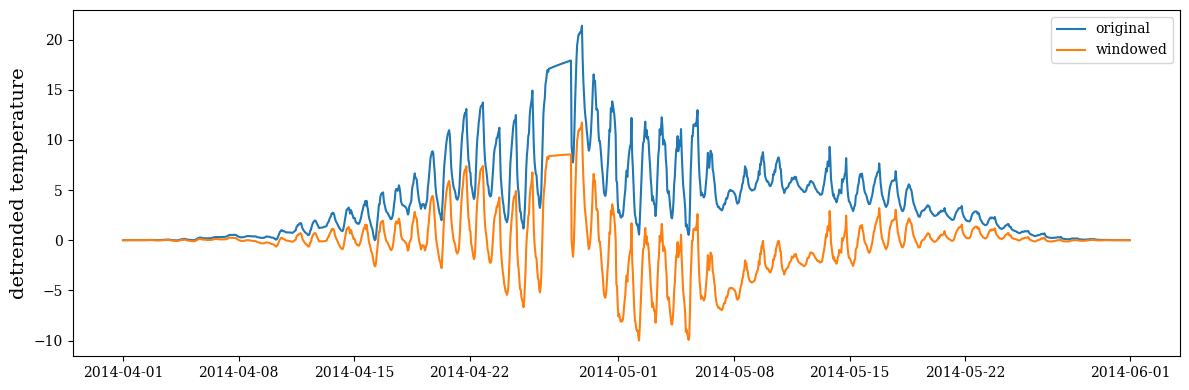

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index, temperature_windowed, label="original")
ax.plot(df.index, temperature_detrended * window, label="windowed")
ax.set_ylabel("detrended temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
# fig.savefig("ch17-temperature-signal.pdf")

In [45]:
f = fftpack.fftfreq(len(temperature_windowed), time[1] - time[0])

In [46]:
mask = f > 0

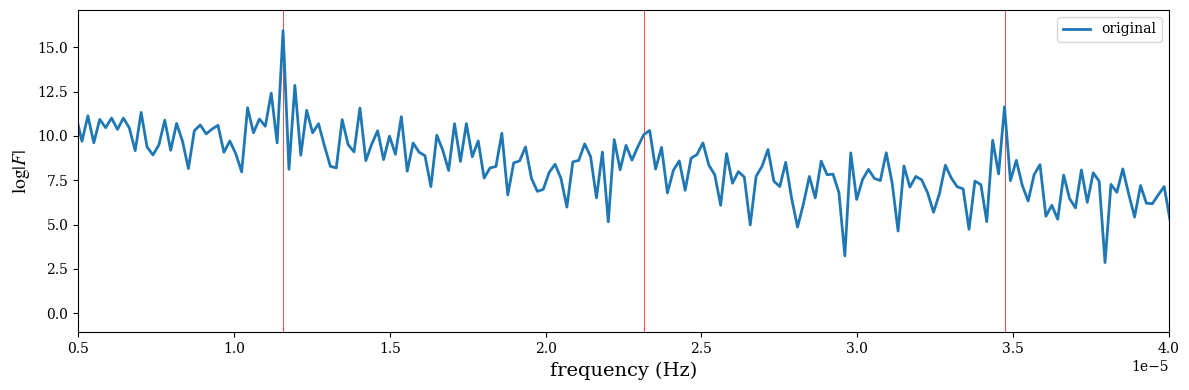

In [47]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xlim(0.000001, 0.000025)
# ax.set_xlim(0.000005, 0.000018)
ax.set_xlim(0.000005, 0.00004)

ax.axvline(1.0 / 86400, color="r", lw=0.5)
ax.axvline(2.0 / 86400, color="r", lw=0.5)
ax.axvline(3.0 / 86400, color="r", lw=0.5)
ax.plot(f[mask], np.log(abs(data_fft[mask]) ** 2), lw=2, label="original")
# ax.plot(f[mask], np.log(abs(data_fft_detrended[mask])**2), lw=2, label="detrended")
# ax.plot(f[mask], np.log(abs(data_fft_windowed[mask])**2), lw=2, label="windowed")
ax.set_ylabel("$\log|F|$", fontsize=14)
ax.set_xlabel("frequency (Hz)", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-spectrum.pdf")

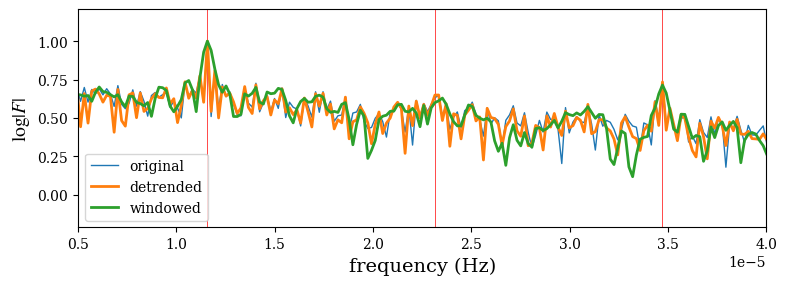

In [48]:
fig, ax = plt.subplots(figsize=(8, 3))
# ax.set_xlim(0.000001, 0.000025)
# ax.set_xlim(0.000005, 0.000018)
ax.set_xlim(0.000005, 0.00004)

ax.axvline(1.0 / 86400, color="r", lw=0.5)
ax.axvline(2.0 / 86400, color="r", lw=0.5)
ax.axvline(3.0 / 86400, color="r", lw=0.5)

y = np.log(abs(data_fft[mask]) ** 2)
ax.plot(f[mask], y / y[10:].max(), lw=1, label="original")

y = np.log(abs(data_fft_detrended[mask]) ** 2)
ax.plot(f[mask], y / y[10:].max(), lw=2, label="detrended")

y = np.log(abs(data_fft_windowed[mask]) ** 2)
ax.plot(f[mask], y / y[10:].max(), lw=2, label="windowed")

ax.set_ylabel("$\log|F|$", fontsize=14)
ax.set_xlabel("frequency (Hz)", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-spectrum.pdf")

## Spectrogram of Guitar sound

In [49]:
# https://www.freesound.org/people/guitarguy1985/sounds/52047/

In [50]:
sample_rate, data = io.wavfile.read("guitar.wav")

In [51]:
sample_rate

44100

In [52]:
data.shape

(1181625, 2)

In [53]:
data = data.mean(axis=1)

In [54]:
data.shape[0] / sample_rate

26.79421768707483

In [55]:
N = int(sample_rate / 2.0)
N  # half a second

22050

In [56]:
f = fftpack.fftfreq(N, 1.0 / sample_rate)

In [57]:
t = np.linspace(0, 0.5, N)

In [58]:
mask = (f > 0) * (f < 1000)

In [59]:
subdata = data[:N]

In [60]:
F = fftpack.fft(subdata)

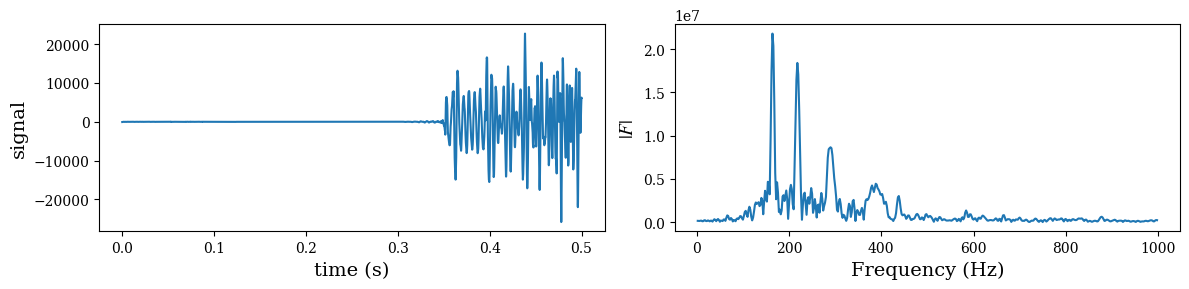

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(t, subdata)
axes[0].set_ylabel("signal", fontsize=14)
axes[0].set_xlabel("time (s)", fontsize=14)
axes[1].plot(f[mask], abs(F[mask]))
axes[1].set_ylabel("$|F|$", fontsize=14)
axes[1].set_xlabel("Frequency (Hz)", fontsize=14)
fig.tight_layout()
fig.savefig("ch17-guitar-spectrum.pdf")

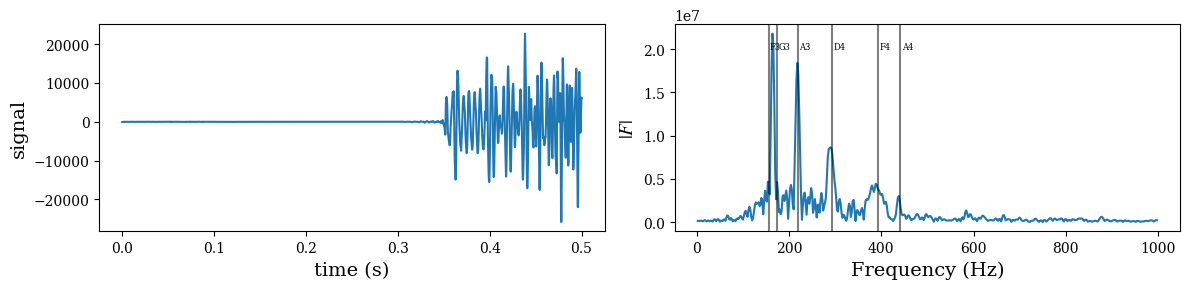

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(t, subdata)
axes[0].set_ylabel("signal", fontsize=14)
axes[0].set_xlabel("time (s)", fontsize=14)
axes[1].plot(f[mask], abs(F[mask]))
axes[1].set_ylabel("$|F|$", fontsize=14)
axes[1].set_xlabel("Frequency (Hz)", fontsize=14)


f_A4 = 440
a = 2 ** (1 / 12)
for note, frequency in [
    # ('A2', f_A4 * a**(-12-12)),
    # ('B2', f_A4 * a**(-10-12)),
    # ('C3', f_A4 * a**(-9-12)),
    # ('D3', f_A4 * a**(-7-12)),
    ("F3", f_A4 * a ** (-6 - 12)),
    ("G3", f_A4 * a ** (-4 - 12)),
    # ('F3', f_A4 * a**(-2-12)),
    ("A3", f_A4 * a ** (-12)),
    # ('B3', f_A4 * a**(-10)),
    # ('C4', f_A4 * a**(-9)),
    ("D4", f_A4 * a ** (-7)),
    # ('F4', f_A4 * a**(-6)),
    # ('G4', f_A4 * a**(-4)),
    ("F4", f_A4 * a ** (-2)),
    ("A4", f_A4),
]:
    axes[1].axvline(frequency, color="black", alpha=0.5)
    axes[1].text(frequency * 1.01, 2e7, note, fontsize=6)

fig.tight_layout()
fig.savefig("ch17-guitar-spectrum.pdf")

In [63]:
N_max = int(data.shape[0] / N)

In [64]:
f_values = np.sum(1 * mask)

In [65]:
spect_data = np.zeros((N_max, f_values))

In [66]:
window = signal.windows.blackman(len(subdata))

In [67]:
for n in range(0, N_max):
    subdata = data[(N * n) : (N * (n + 1))]
    F = fftpack.fft(subdata * window)
    spect_data[n, :] = np.log(abs(F[mask]))

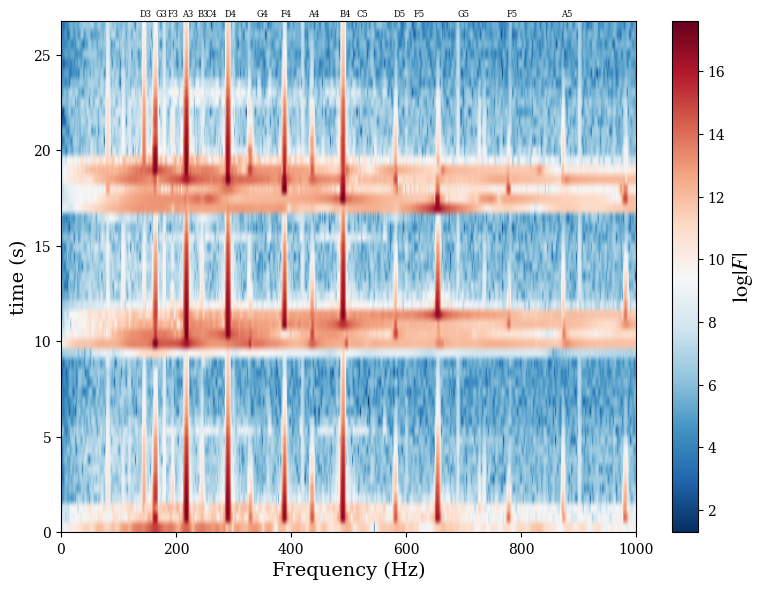

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
p = ax.imshow(
    spect_data,
    origin="lower",
    extent=(0, 1000, 0, data.shape[0] / sample_rate),
    aspect="auto",
    cmap=mpl.cm.RdBu_r,
)
cb = fig.colorbar(p, ax=ax)
cb.set_label("$\log|F|$", fontsize=16)
ax.set_ylabel("time (s)", fontsize=14)
ax.set_xlabel("Frequency (Hz)", fontsize=14)


f_A4 = 440
a = 2 ** (1 / 12)
for note, frequency in [
    # ('A2', f_A4 * a**(-12-12)),
    # ('B2', f_A4 * a**(-10-12)),
    # ('C3', f_A4 * a**(-9-12)),
    ("D3", f_A4 * a ** (-7 - 12)),
    # ('F3', f_A4 * a**(-6-12)),
    ("G3", f_A4 * a ** (-4 - 12)),
    ("F3", f_A4 * a ** (-2 - 12)),
    ("A3", f_A4 * a ** (-12)),
    ("B3", f_A4 * a ** (-10)),
    ("C4", f_A4 * a ** (-9)),
    ("D4", f_A4 * a ** (-7)),
    # ('F4', f_A4 * a**(-6)),
    ("G4", f_A4 * a ** (-4)),
    ("F4", f_A4 * a ** (-2)),
    ("A4", f_A4),
    ("B4", f_A4 * a ** (2)),
    ("C5", f_A4 * a ** (3)),
    ("D5", f_A4 * a ** (5)),
    ("F5", f_A4 * a ** (6)),
    ("G5", f_A4 * a ** (8)),
    ("F5", f_A4 * a ** (10)),
    ("A5", f_A4 * a ** (12)),
]:
    # ax.axvline(frequency, color="black", alpha=0.5)
    ax.text(frequency - 10, 27, note, fontsize=6)

fig.tight_layout()
fig.savefig("ch17-spectrogram.pdf")
fig.savefig("ch17-spectrogram.png")

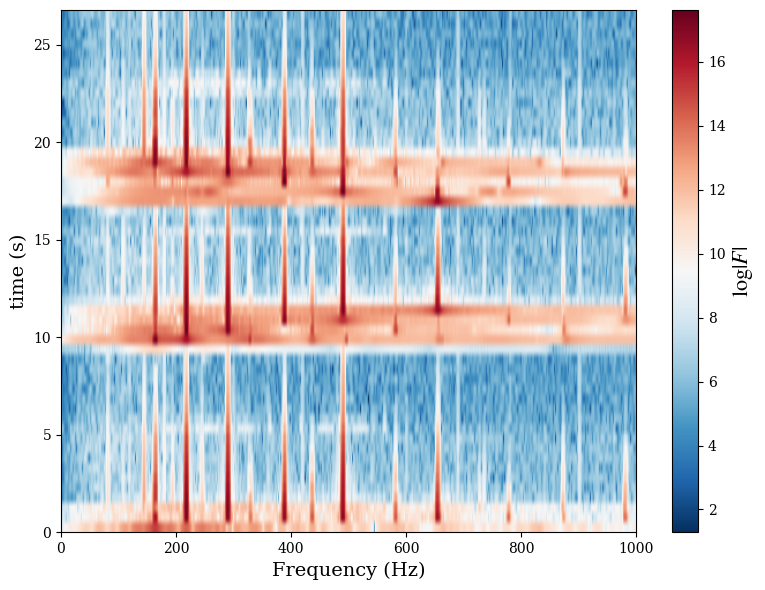

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
p = ax.imshow(
    spect_data,
    origin="lower",
    extent=(0, 1000, 0, data.shape[0] / sample_rate),
    aspect="auto",
    cmap=mpl.cm.RdBu_r,
)
cb = fig.colorbar(p, ax=ax)
cb.set_label("$\log|F|$", fontsize=16)
ax.set_ylabel("time (s)", fontsize=14)
ax.set_xlabel("Frequency (Hz)", fontsize=14)
fig.tight_layout()
fig.savefig("ch17-spectrogram.pdf")
fig.savefig("ch17-spectrogram.png")

## Signal filters

### Convolution filters

In [70]:
# restore variables from the first example
np.random.seed(0)
B = 30.0
f_s = 2 * B
delta_f = 0.01
N = int(f_s / delta_f)
T = N / f_s
t = np.linspace(0, T, N)
f_t = signal_samples(t)
f = fftpack.fftfreq(N, 1 / f_s)

In [71]:
H = abs(f) < 2

In [72]:
h = fftpack.fftshift(fftpack.ifft(H))

In [73]:
f_t_filtered_conv = signal.convolve(f_t, h, mode="same")

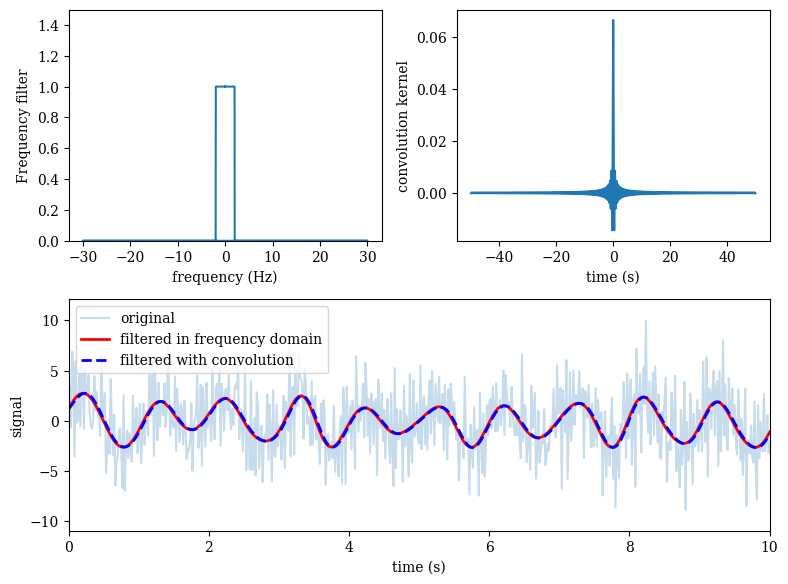

In [74]:
fig = plt.figure(figsize=(8, 6))

ax = plt.subplot2grid((2, 2), (0, 0))
ax.plot(f, H)
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("Frequency filter")
ax.set_ylim(0, 1.5)

ax = plt.subplot2grid((2, 2), (0, 1))
ax.plot(t - t[-1] / 2.0, h.real)
ax.set_xlabel("time (s)")
ax.set_ylabel("convolution kernel")

ax = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax.plot(t, f_t, label="original", alpha=0.25)
ax.plot(t, f_t_filtered.real, "r", lw=2, label="filtered in frequency domain")
ax.plot(t, f_t_filtered_conv.real, "b--", lw=2, label="filtered with convolution")
ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
ax.legend(loc=2)

fig.tight_layout()
fig.savefig("ch17-convolution-filter.pdf")
fig.savefig("ch17-convolution-filter.png")

### FIR filter

In [75]:
n = 101

In [76]:
f_s = 1.0 / 3600

In [77]:
nyq = f_s / 2

In [78]:
b = signal.firwin(n, cutoff=nyq / 12, fs=nyq, window="hamming")

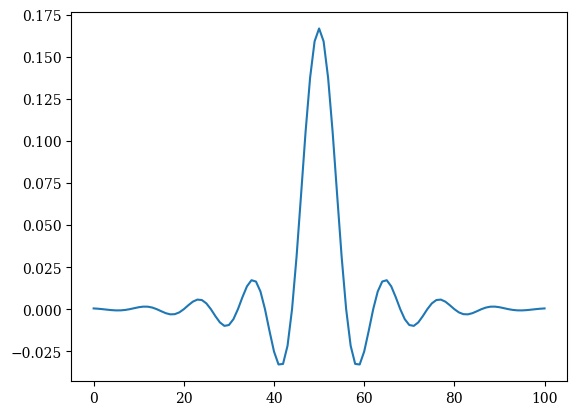

In [79]:
plt.plot(b);

In [80]:
f, h = signal.freqz(b)

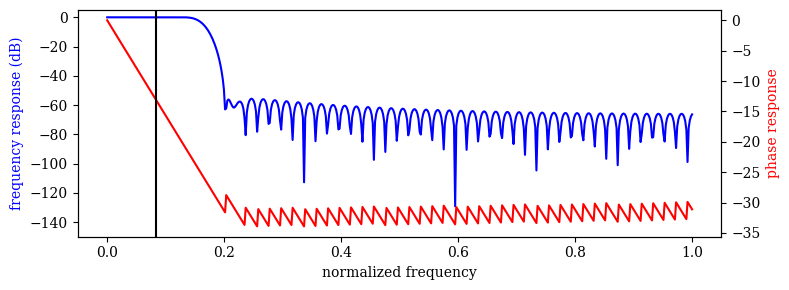

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
h_ampl = 20 * np.log10(abs(h))
h_phase = np.unwrap(np.angle(h))
ax.plot(f / max(f), h_ampl, "b")
ax.set_ylim(-150, 5)
ax.set_ylabel("frequency response (dB)", color="b")
ax.set_xlabel(r"normalized frequency")
ax = ax.twinx()
ax.plot(f / max(f), h_phase, "r")
ax.set_ylabel("phase response", color="r")
ax.axvline(1.0 / 12, color="black")
fig.tight_layout()
fig.savefig("ch17-filter-frequency-response.pdf")

In [82]:
temperature_filtered = signal.lfilter(b, 1, temperature)

In [83]:
temperature_median_filtered = signal.medfilt(temperature, 25)

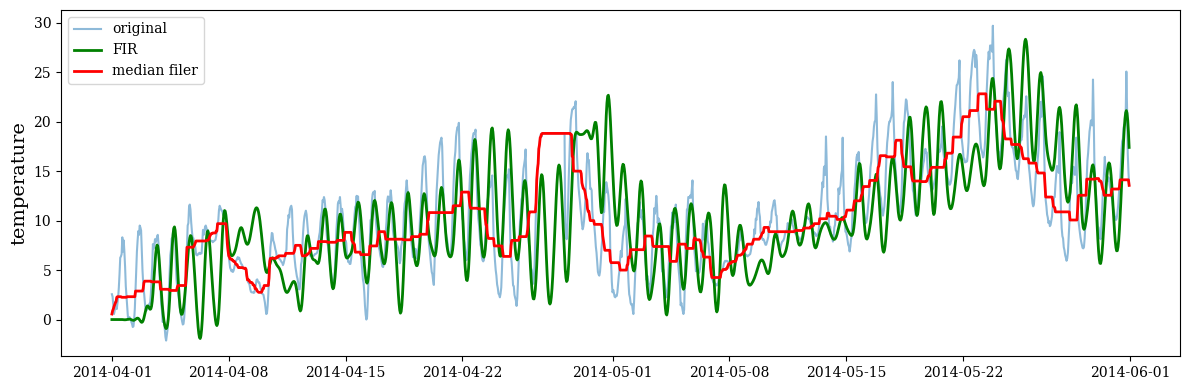

In [84]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_filtered, color="green", lw=2, label="FIR")
ax.plot(df.index, temperature_median_filtered, color="red", lw=2, label="median filer")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-signal-fir.pdf")

### IIR filter

In [85]:
b, a = signal.butter(2, 14 / 365.0, btype="high")

In [86]:
b

array([ 0.91831745, -1.8366349 ,  0.91831745])

In [87]:
a

array([ 1.        , -1.82995169,  0.8433181 ])

In [88]:
temperature_filtered_iir = signal.lfilter(b, a, temperature)

In [89]:
temperature_filtered_filtfilt = signal.filtfilt(b, a, temperature)

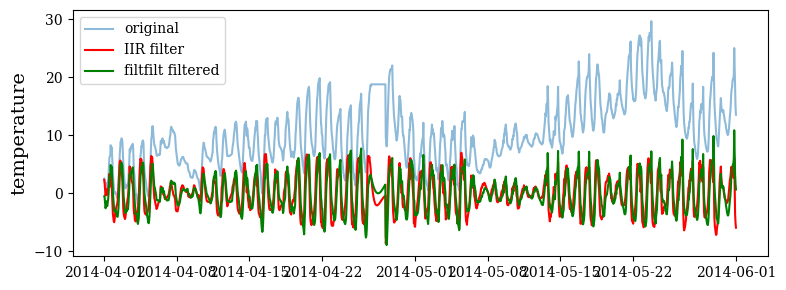

In [90]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_filtered_iir, color="red", label="IIR filter")
ax.plot(
    df.index, temperature_filtered_filtfilt, color="green", label="filtfilt filtered"
)
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-signal-iir.pdf")

In [91]:
# f, h = signal.freqz(b, a)

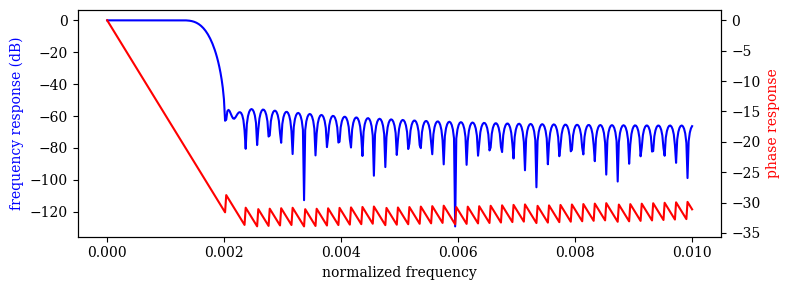

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
h_ampl = 20 * np.log10(abs(h))
h_phase = np.unwrap(np.angle(h))
ax.plot(f / max(f) / 100, h_ampl, "b")
ax.set_ylabel("frequency response (dB)", color="b")
ax.set_xlabel(r"normalized frequency")
ax = ax.twinx()
ax.plot(f / max(f) / 100, h_phase, "r")
ax.set_ylabel("phase response", color="r")
fig.tight_layout()

### Filtering Audio

In [93]:
b = np.zeros(5000)
b[0] = b[-1] = 1
b /= b.sum()

In [94]:
data_filt = signal.lfilter(b, 1, data)

In [95]:
io.wavfile.write(
    "guitar-echo.wav", sample_rate, np.vstack([data_filt, data_filt]).T.astype(np.int16)
)

In [99]:
# based on: http://nbviewer.ipython.org/gist/Carreau/5507501/the%20sound%20of%20hydrogen.ipynb
from IPython.core.display import HTML
from IPython.display import display


def wav_player(filepath):
    src = """
    <audio controls="controls" style="width:600px" >
      <source src="%s" type="audio/wav" />
    </audio>
    """ % (filepath)
    display(HTML(src))

In [100]:
wav_player("guitar.wav")

In [101]:
wav_player("guitar-echo.wav")